# Atividade com Xcompact3d-toolbox

O objetivo deste notebook é exercitar conceitos de cálculo numérico e de CFD, como definição da resolução da malha e pós-processamento dos dados gerados por uma simulação. Esses conceitos são trabalhados a partir da ferramenta [Xcompact3d-toolbox](https://docs.fschuch.com/xcompact3d_toolbox/) que foi abordada em aulas anteriores.

Nesta atividade, se abordará novamente o caso do escoamento ao redor de um corpo, porém será explorada uma configuração diferente, consistindo em um arranjo com três cilindros. Este documento é organizado em duas atividades: I) na primeira, o exercício é definir a configuração e a geometria da simulação, II) na segunda etapa será implementado o pós-processamento da simulação. Não modifique o código deste notebook a menos que solicitado. Quando isso for solicitado, o espaço para escrever o código ficará entre os comentários `# Seu código vai aqui` e `# Fim`.

Para resolução dos exercícios propostos neste notebook, além de consultar os materiais apresentados nas aulas anteriores, é fortemente recomendado consultar a documentação do [Xcompact3d-toolbox](https://docs.fschuch.com/xcompact3d_toolbox/). Também é recomendado verificar a documentação das bibliotecas [xarray](https://docs.xarray.dev/en/stable/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/) e [hvplot](https://hvplot.holoviz.org/en/docs/latest/index.html).

# Instalação

O ambiente do LAD deve conter todas as dependências necessárias, porém as linhas abaixo podem ser usadas para instalar as bibliotecas exigidas para esse notebook usando [pip](https://pip.pypa.io/en/stable/). Se mesmo assim seu ambiente de trabalho ainda não contiver todas as bibliotecas necessárias, utilize [pip](https://pip.pypa.io/en/stable/) ou qualquer outro gerenciador de pacotes para instalar as bibliotecas python necessárias.

In [ ]:
#!pip install xcompact3d_toolbox

In [ ]:
#!pip install hvplot

In [ ]:
#!pip install datashader

# Importando bibliotecas

Execute o código abaixo para importar as bibliotecas necessárias para a execução deste notebook.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
import hvplot.xarray
import xcompact3d_toolbox as x3d

import warnings
warnings.filterwarnings('ignore')

# Atividade 1: definindo a configuração do experimento

Neste notebook se abordará o caso de um escoamento ao redor de um corpo, porém dessa vez se abordará um arranjo composto por três cilindros, como no vídeo abaixo:

<video width="320" height="240" src = "img/threecylinder.mp4" autoplay loop></video>

Na primeira etapa deste notebook, é trabalhado como se definir os parâmetros e a geometria da simulação.

## a. Inicializando os parâmetros da simulação


Inicialize os parâmetros para a configuração de um escoamento com três cilindros para um número de Reynolds 300. O domínio espacial é um paralelepípedo de dimensões Lx * Ly * Lz tridimensional com os seguintes comprimentos:

- Lx = 15
- Ly = 10
- Lz = 3

Para isso, utilize a classe `ParametersGui`, que permite definir os parâmetros da simulação utilizando uma interface interativa com [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/). Execute a célula abaixo para gerar uma instância da classe `ParametersGui`.

In [ ]:
prm = x3d.ParametersGui(
    filename="input.i3d",
    itype=12,
    p_row=0,
    p_col=0,
    xlx = 15,
    yly = 10,
    zlz = 3,
    nclx1=0,
    nclxn=0,
    ncly1=0,
    nclyn=0,
    nclz1=1,
    nclzn=1,
    iin=1,
    iibm=2,
    nu0nu=4.0,
    cnu=0.44,
    irestart=0,
    icheckpoint=45000,
    ioutput=200,
    iprocessing=50,
    jles=4,
)

A configuração deste notebook possui as seguintes condições de contorno:

- Condição de entrada em x = 0 e saída em x = Lx
- Deslizamento livre em y = 0 e y = Ly
- Periódico em z = 0 e z = Lz

Execute a célula de código abaixo e utilize a interface do [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) para impor essas condições ao domínio.

Lembrando que:

- nclx1 parâmetro para condição de contorno em x = 0
- nclxn parâmetro para condição de contorno em x = Lx
- ncly1 parâmetro para condição de contorno em y = 0
- nclyn parâmetro para condição de contorno em y = Ly
- nclz1 parâmetro para condição de contorno em z = 0
- nclzn parâmetro para condição de contorno em z = Lz

In [ ]:
prm("nclx1", "nclxn", "ncly1", "nclyn","nclz1", "nclzn")

Com as condições de contorno definidas, execute a célula abaixo e defina o número de pontos em `nx`, `ny` e `nz`. Lembrando que o domínio deve possuir as seguintes dimensões:

- Lx = 15
- Ly = 10
- Lz = 3

A malha deve possuir a seguinte resolução

- dx = 0.117
- dy = 0.156
- dz = 0.094

<u>Dica</u>: lembrando que podemos calcular o número de pontos em x, y e z como `nx=Lx*dx`, `ny=Ly*dy` e `nz=Lz*dz`.

In [ ]:
prm("nx", "ny","nz")

Podemos visualizar os parâmetros definidos com a célula de código abaixo.

In [ ]:
for var in "nclx1 nclxn ncly1 nclyn nclz1 nclzn xlx yly zlz nx ny nz dx dy dz".split():
  print(f"{var:>5} = {getattr(prm, var)}")

## b. Definindo a geométria

Agora, com os parâmetros já definidos, gere a geometria da configuração. Crie um arranjo com três cilindros de raio `r = 1.0` com os centros posicionados em `C1=(5,2.5)`, `C2=(5,7.5)` e `C1=(7.5,5)`. Como ilustração, a visualização da malha deve ser algo próximo a:

<img src = "img/threeCylinderCoarse.png">

Para gerar a malha, a linha de código `epsi = x3d.init_epsi(prm)` gera um dicionário com as quatro matrizes $\epsilon$. Para adicionar um cilindro no domínio, pode-se utilizar o método `geo.cylinder(x,y)` e usar um loop `for` para que a máscara seja adicionada em todas as matrizes. Como exemplo, o código abaixo adiciona um único cilindro com centro na posição (7.5,5):

```
for key in epsi:
    epsi[key] = epsi[key].geo.cylinder(7.5,5)
```

Esse código gera a seguinte geométria:

<img src = "img/Cylinder.png">

Na célula abaixo, implemente a função `geo` a qual deve gerar o arranjo com os três cilindros.

<font color="red"><u>IMPORTANTE</u></font>: escreva o seu código unicamente entre as linhas `# Seu código vai aqui` e `# Fim`. Não modifique o resto da célula.

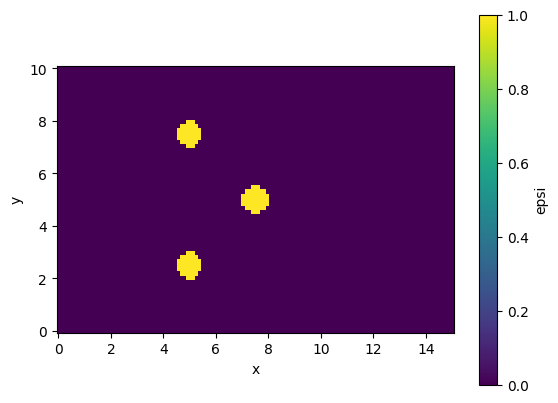

In [ ]:
epsi = x3d.init_epsi(prm)

def geo(epsi):
  for key in epsi:
    # Seu código vai aqui
    epsi[key] = epsi[key].geo.cylinder(x=5, y=prm.yly / 4.0)
    epsi[key] = epsi[key].geo.cylinder(x=5, y=3*prm.yly / 4.0)
    epsi[key] = epsi[key].geo.cylinder(x=7.5, y=prm.yly / 2.0)
    # Fim

geo(epsi)

g = epsi["epsi"].sel(z=0, method="nearest").plot(x="x")
g.axes.set_aspect("equal")
g.axes.set_title("");

## c. Refinando a malha

Excelente, você conseguiu descrever a geometria, porém ainda podemos melhorar um pouco este arranjo. Se você observar bem a visualização da malha, há de notar a superfície pontiaguda na borda dos cilindros, isso é decorrente da resolução da malha que não possui uma resolução fina o suficiente para descrever uma superfície mais arredondada.

Como exemplo, utilizando os valores de `nx=257` e `ny=129` a malha deve ficar como a imagem abaixo:

<img src = "img/threeCylinder.png">

Melhore a resolução da malha, execute a célula abaixo e utilize a interface dos widgets para aumentar o número de pontos em `x` e `y`.

In [ ]:
prm("nx", "ny")

Execute a célula abaixo para gerar a nova malha e veja como ficou mais refinada a superfície do cilindro. Como a descrição do arranjo já foi implementada no exercício anterior na função `geo`, só precisamos chamá-la novamente para gerar geometria.

In [ ]:
epsi = x3d.init_epsi(prm)

geo(epsi)

g = epsi["epsi"].sel(z=0, method="nearest").plot(x="x")
g.axes.set_aspect("equal")
g.axes.set_title("");

Com a malha definida, pode-se salvá-la no disco para posteriormente executar a simulação utilizando o solver do `Xcompact3d`. Isso pode ser feito com o seguinte comando no terminal:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```

Não será exigido executar a simulação, porém para as próximas atividades serão utilizados dados provenientes de uma simulação com essa configuração.

# Atividade 2: pós-processamento

Nesta atividade, o objetivo é pós-processar os dados gerados por uma simulação. Como exercício, continuaremos com o arranjo com três cilindros, porém utilizaremos apenas um plano bidimensional em `xy` devido ao tamanho da simulação. Neste notebook serão exploradas duas grandezas: i) a energia cinética e ii) a vorticidade do escoamento.

## Carregando dados

Na célula abaixo, é carregado na memória os dados do plano `xy` no formato de um objeto xarray.

In [ ]:
# Abrindo o banco de dados
dataset = xr.open_dataset("cylinder_plane_xy.nc")
dataset

##  Energia cinética

Como primeira atividade de pós-processamento, pede-se que seja feito o cáluclo da energia cinética do escoamento, definido pela equação abaixo:

$$
k = \int_V \dfrac{u_iu_i}{2} dV
$$

Complete a célula abaixo com o cálculo da energia cinética, sendo que o resultado deve ser armazenado no objeto xarray, isso pode ser feito atribuindo uma nova variável ao banco de dados com o seguinte comando:

```
dataset["kinetic_energy"] = resultado_do_calculo_de_k
```

<font color="red"><u>IMPORTANTE</u></font>: para funcionamento das células seguintes, é imprescindível que o resultado do cálculo seja armazenado no objeto `dataset` exatamente como na linha de código anterior. Você tem a liberdade total em como fazer esse cálculo, porém com xarray é possível, em uma única linha de código, realizar esse cálculo.

<u>Dica 1</u>: xarray é construído sobre [numpy](https://numpy.org/) arrays, permitindo operações aritméticas entre `datasets` como se fossem arrays numpy. Assim, para aplicar uma operação aritmética entre dois `dataset` pode-se usar a linha abaixo:

```
A*B
```

Onde `A` e `B` são dois xarray diferentes, também pode-se aplicar operações com constantes sobre o `dataset` com

```
0.5*A
```

Para aplicar uma exponencial sobre o `dataset` pode-se usar um código similar a

```
A**2
```

<u>Dica 2</u>: para aplicar uma operação de redução sobre o `dataset` pode-se usar o método `sum`, assim para somar todos os elementos no eixo `x` pode-se usar o código:

```
dataset.sum("x")
```

<u>Dica 3</u>: para aplicar uma função sobre o `dataset` pode-se usar qualquer função já compatível com um numpy array. Como exemplo, veja abaixo o código com a aplicação para a integral de Simpson da biblioteca [scipy](https://scipy.org/).

```
scipy.integrate.simps(dataset, dataset.coords['x'])
```

In [ ]:
# Cálculo da energia cinética
dataset["kinetic_energy"] = ((dataset.ux**2+dataset.uy**2).x3d.simpson("x", "y")) * 0.5

Podemos visualizar o resultado do pós-processamento com o método `plot`. Execute a célula abaixo e observe o gráfico.

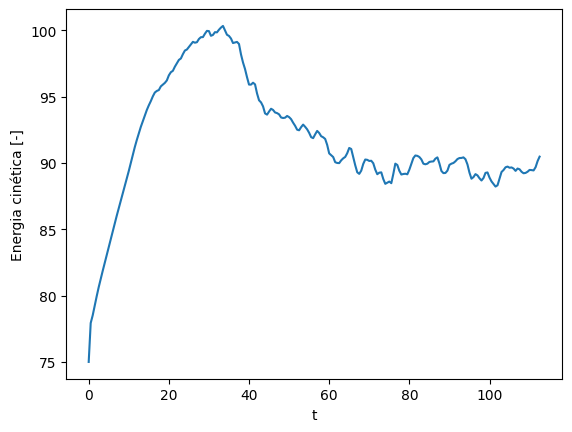

In [ ]:
dataset["kinetic_energy"].attrs = {"name": "k", "long_name": "Energia cinética", "units": "-"}
dataset["kinetic_energy"].plot();

## b. Cálculo da vorticidade

Como próxima atividade, pede-se que seja feito o cálculo da vorticidade, dado pela equação:

$$
\omega_z = \dfrac{\partial u_y}{\partial x}  - \dfrac{\partial u_x}{\partial y}
$$

Complete a célula de código abaixo com o cálculo da vorticidade, sendo que o resultado deve ser armazenado no objeto xarray, isso pode ser feito atribuindo uma nova variável ao banco de dados com o seguinte comando:

```
dataset["vort"] = resultado_do_calculo_de_w
```

<font color="red"><u>IMPORTANTE</u></font>: para funcionamento das células seguintes, é imprescindível que o resultado do cálculo seja armazenado no objeto `dataset` exatamente como na linha de código anterior. Você tem a liberdade total em como fazer esse cálculo, porém, com xarray, é possível, em uma única linha de código, realizar esse cálculo.

<u>Dica</u>: Xcompact3d-toolbox possui métodos para o cálculo numérico de derivadas. Por exemplo, para calcular a derivada $\dfrac{∂u_y}{∂x}$ pode-se utilizar a seguinte linha de código:

```
dataset.uy.x3d.first_derivative("x")
```

In [ ]:
dataset["vort"] = dataset.uy.x3d.first_derivative("x") - dataset.ux.x3d.first_derivative("y")

Para visualizar o pós-processamento, execute a célula abaixo para gerar uma animação.

In [ ]:
dataset.vort.hvplot(
    x="x",
    y="y",
    aspect="equal",
    clim=(-5, 5),
    rasterize=True,
    cmap="turbo",
    widget_type="scrubber",
    widget_location="bottom",
    title="Escoamento ao redor de um arranjo com três cilindros",
    clabel="Vorticidade [-]",
)